In [1]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from models.load import get_trained_model
from data.datasets import  OurRadiologsitsDataset, collate_fn
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from data.datasets import ReflacxDataset, collate_fn
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": False,
        "dataset_mode": "normal",
        "bbox_to_mask": False,
        "normalise_clinical_num": False,
        "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
    }
    
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

In [4]:
def plot_gts_for_dataset_idx(
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    dicom_id = data[-1][0]['dicom_id']

    idxs = detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)

    img, target = data

    targets = [ dataset.prepare_input_from_data(collate_fn([dataset[i]]), device)[1][0] for i in idxs ]

    bb_fig = plot_gts_for_model(
        idx=idx,
        target=target[0],
        targets = targets,
        label_idx_to_disease=dataset.label_idx_to_disease,
        legend_elements=legend_elements,
        disease_color_code_map=disease_cmap["solid"],
    )

    return bb_fig


def plot_gts_for_model(
    idx: int,
    target: List[Dict],
    targets: List[Dict],
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
) -> Figure:
    # clinical + original image + preds
    
    slot_size = len(targets)

    fig, axes = plt.subplots(
        1, slot_size, figsize=(10*slot_size, 10), dpi=120, sharex=True, squeeze= False
    )

    img_path = target["image_path"]
    dicom_id = os.path.basename(img_path).split(".")[0]
    fig.suptitle(f"{dicom_id} ({idx})")
    fig.legend(handles=legend_elements, loc="upper right")
    img = PIL.Image.open(target["image_path"]).convert("RGB")

    for ax in axes[0]:
        ax.imshow(img)

    for ax, t in zip(axes[0], targets):
        ax.set_title(
            f"Ground Truth ({len(t['boxes'].detach().cpu().numpy())})"
        )

    for ax, t in zip(axes[0], targets):
        label = t["labels"].detach().cpu().numpy()
        bbox = t["boxes"].detach().cpu().numpy()

        for label, bbox in zip(
            t["labels"].detach().cpu().numpy(),
            t["boxes"].detach().cpu().numpy(),
        ):

            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            ax.add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            ax.text(
                bbox[0], bbox[1], disease, color="black", backgroundcolor=c
            )
        
    return fig

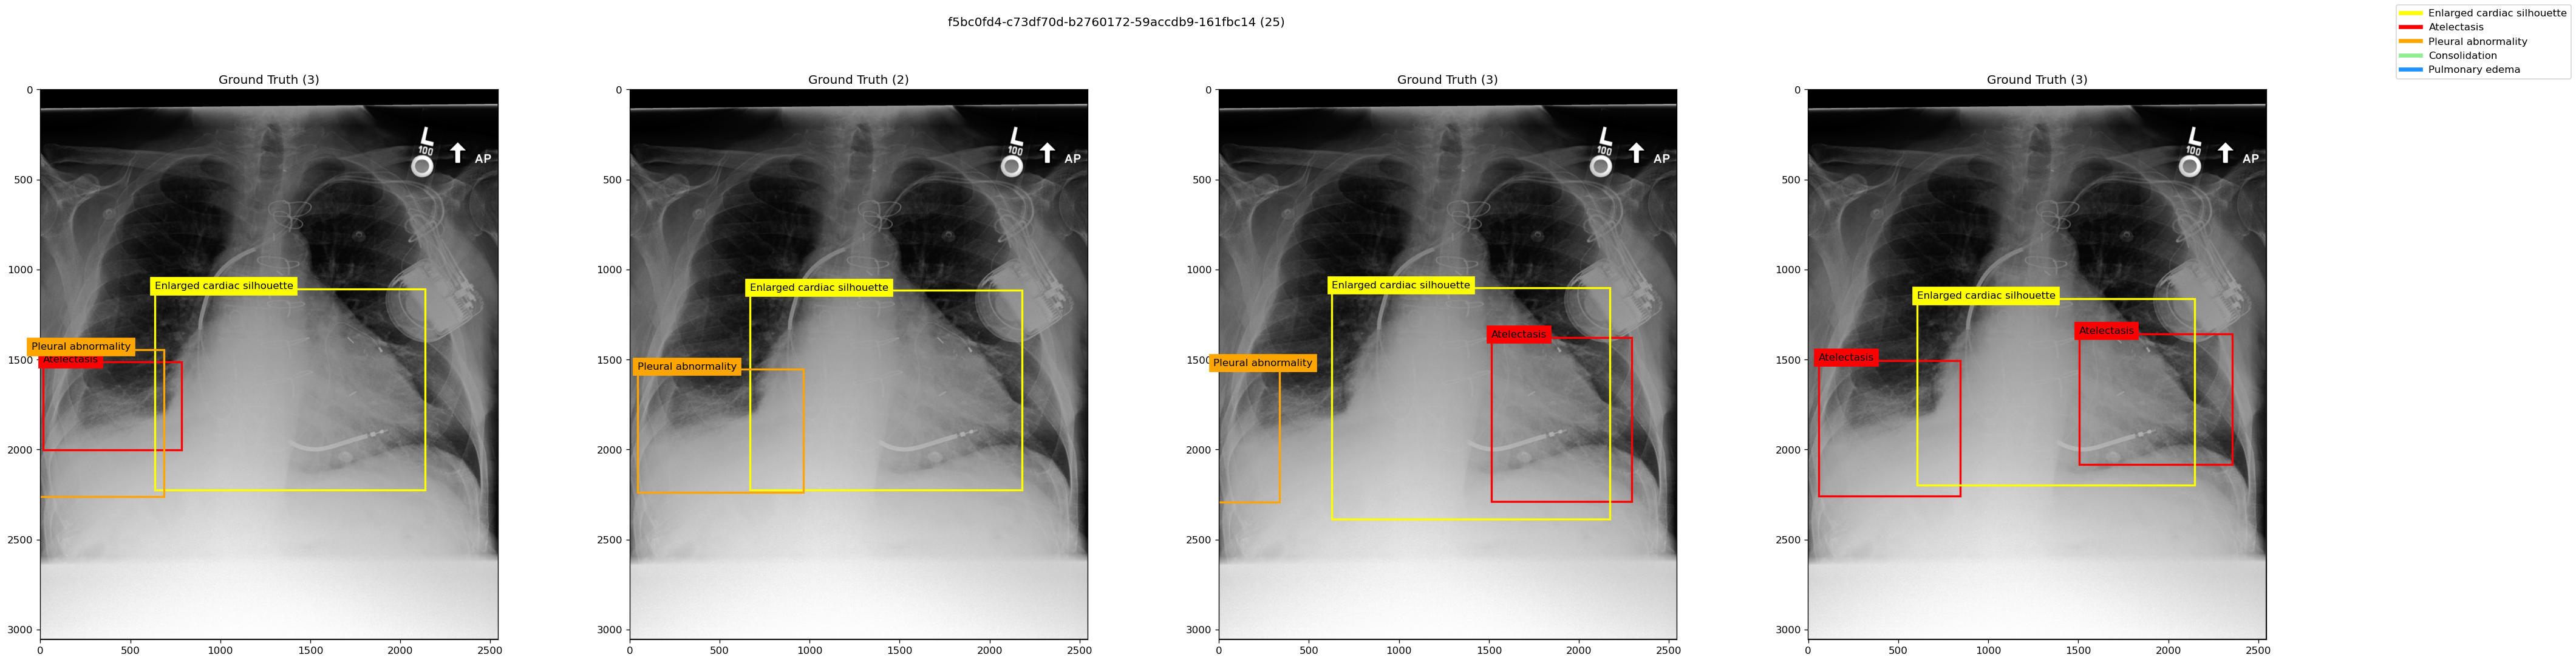

In [5]:
# for generating the example in the paper.

fig = plot_gts_for_dataset_idx(
    dataset=detect_eval_dataset,
    device=device,
    idx=25,
    legend_elements=legend_elements,
    disease_cmap=DISEASE_CMAP,
)



In [6]:
### modify the naming here.

commented_idxs = [
    10, 12, 14,31,37, 90, 118, 181, 187, 190, 205, 210, 222, 247, 250, 268, 294, 315, 463, 484, 548, 557, 614, 625, 634,
]

from tqdm import tqdm

destination_folder = os.path.join(
    "REFLACX_GROUNDTRUTH_DIFF"
)

os.makedirs(destination_folder, exist_ok=True)

for idx in tqdm(commented_idxs):

    fig = plot_gts_for_dataset_idx(
        dataset=detect_eval_dataset,
        device=device,
        idx=idx,
        legend_elements=legend_elements,
        disease_cmap=DISEASE_CMAP,
    )
    instance = detect_eval_dataset.df.iloc[idx]
    fig.savefig(
        os.path.join(
            destination_folder,
            f"({idx}) {instance['dicom_id']}.png",
        )
    )
    plt.cla()
    plt.clf()
    plt.close("all")


100%|██████████| 25/25 [00:41<00:00,  1.68s/it]


In [7]:
def plot_gt_for_dataset_idx(
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    # we first get all the idxs of with the same dicomid

    data = dataset.prepare_input_from_data(data, device)
    imgs, targets = data


    bb_fig = plot_gt_for_model(
        idx=idx,
        target=targets[0],
        label_idx_to_disease=dataset.label_idx_to_disease,
        legend_elements=legend_elements,
        disease_color_code_map=disease_cmap["solid"],
    )

    return bb_fig


def plot_gt_for_model(
    idx: int,
    target: List[Dict],
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
) -> Figure:
    # clinical + original image + preds
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 10), dpi=120, sharex=True, 
    )
    img_path = target["image_path"]
    dicom_id = os.path.basename(img_path).split(".")[0]
    fig.suptitle(f"{dicom_id} ({idx})")
    fig.legend(handles=legend_elements, loc="upper right")
    img = PIL.Image.open(target["image_path"]).convert("RGB")

    ax.imshow(img)

    ax.set_title(
        f"Ground Truth ({len(target['boxes'].detach().cpu().numpy())})"
    )

    for label, bbox in zip(
        target["labels"].detach().cpu().numpy(),
        target["boxes"].detach().cpu().numpy(),
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        ax.add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        ax.text(
            bbox[0], bbox[1], disease, color="black", backgroundcolor=c
        )
        
    return fig

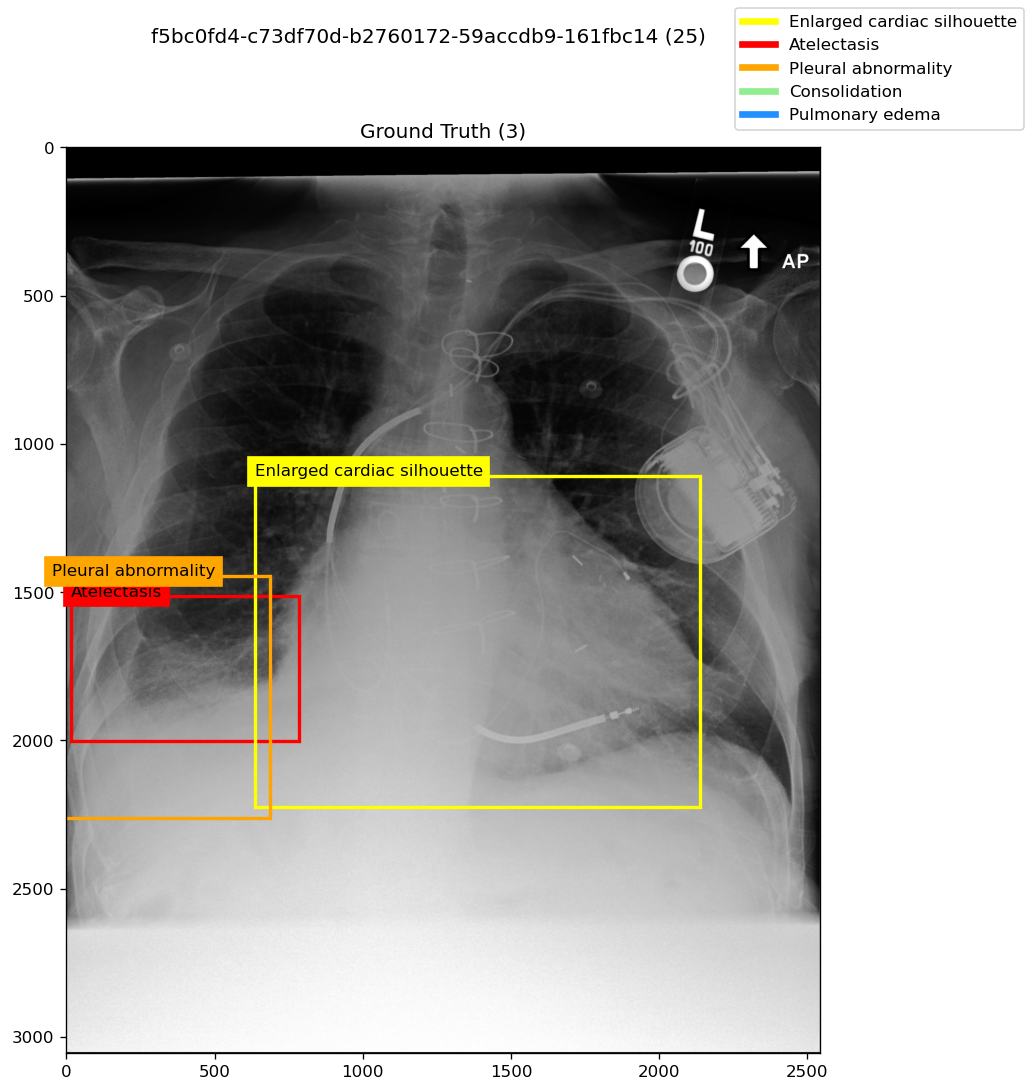

In [8]:
# for generating the example in the paper.

fig = plot_gt_for_dataset_idx(
    dataset=detect_eval_dataset,
    device=device,
    idx=25,
    legend_elements=legend_elements,
    disease_cmap=DISEASE_CMAP,
)



In [9]:
### modify the naming here.
from tqdm import tqdm

commented_idxs = [
    10, 12, 14,31,37, 90, 118, 181, 187, 190, 205, 210, 222, 247, 250, 268, 294, 315, 463, 484, 548, 557, 614, 625, 634,
]

destination_folder = os.path.join(
    "REFLACX_GROUNDTRUTH"
)

os.makedirs(destination_folder, exist_ok=True)

for idx in tqdm(commented_idxs):

    fig = plot_gt_for_dataset_idx(
        dataset=detect_eval_dataset,
        device=device,
        idx=idx,
        legend_elements=legend_elements,
        disease_cmap=DISEASE_CMAP,
    )
    instance = detect_eval_dataset.df.iloc[idx]
    fig.savefig(
        os.path.join(
            destination_folder,
            f"({idx}) {instance['dicom_id']}.png",
        )
    )
    plt.cla()
    plt.clf()
    plt.close("all")


100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


In [1]:
import torch

In [ ]:
torch.nn.functional.conv_transpose2d
